# RNNs and sequence processing

## Tutorial and homework 1: Sentiment Analysis

We will look at a simple example of sequence processing in sentiment analysis. Sentiment analysis is used to determine the emotion in a text. 

We will use a data set from IMDB consisting of movie reviews and are only interested if they are positive or negative (http://ai.stanford.edu/~amaas/data/sentiment/)

In addition to the libraries installed last time, we will also neet torchtext and datasets: 

pip install torchtext
pip install datasets

In [1]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import os
import re
from collections import Counter

/Users/marbetschar/miniconda3/envs/ZHAW-Advanced-Deep-Learning/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

### Loading and Preprocessing the IMDb Dataset

We’ll use datasets to load and preprocess the IMDb dataset (it is also available from torchtext)
- TorchText makes it easy to handle text data, including tokenization, padding, and batch generation.
- IMDB Dataset consists of movie reviews labeled as positive or negative.

In [3]:
train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])
train_data

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

### Tokenizer
We will use a tokinizer to split the sentences in words. This tokenizer will normalize english text first and then extract the words.

In [5]:
# Replacement for torchtext.data.utils.get_tokenizer("basic_english")
def basic_english_tokenizer(text: str):
    text = text.lower()
    # Unify HTML breaks etc.
    text = text.replace("<br />", " ")
    # Separate punctuation (keep apostrophes for contractions)
    text = re.sub(r"([.,!?;:()\"“”‘’\-])", r" \1 ", text)
    # Collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text.split()

tokenizer = basic_english_tokenizer

In [6]:
def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    length = len(tokens)
    return {"tokens": tokens, "length": length}

### Token sequence
This will transfer the input data into sequences of words of a maximal length. While the model does not require the sequences to have the same length, it is needed for batch processing later.

We then split the data sets.

In [7]:
max_length = 256

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

Map: 100%|██████████| 25000/25000 [00:01<00:00, 17750.94 examples/s]


In [8]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

### Vocabulary

Next we build the vocabulary of all words in the set and add two special "words" for unknown and padding.

In [9]:
# Replacement for torchtext.vocab.build_vocab_from_iterator and torchtext.vocab.Vocab
class Vocab:
    def __init__(self, counter: Counter, min_freq: int = 1, specials=None):
        if specials is None:
            specials = []
        # Ensure special tokens are at the beginning
        self.itos = list(specials)
        # Filter tokens by min_freq and exclude specials duplicates
        tokens = [tok for tok, freq in counter.items() if freq >= min_freq and tok not in specials]
        tokens.sort()
        self.itos.extend(tokens)
        self.stoi = {tok: idx for idx, tok in enumerate(self.itos)}
        self.default_index = 0  # default to first special (e.g., <unk>)

    def __len__(self):
        return len(self.itos)

    def __getitem__(self, token: str) -> int:
        return self.stoi.get(token, self.default_index)

    def set_default_index(self, idx: int):
        self.default_index = idx

    def get_itos(self):
        return self.itos

    def lookup_indices(self, tokens):
        return [self.stoi.get(t, self.default_index) for t in tokens]

min_freq = 5
special_tokens = ["<unk>", "<pad>"]

token_counter = Counter()
for tokens in train_data["tokens"]:
    token_counter.update(tokens)

vocab = Vocab(token_counter, min_freq=min_freq, specials=special_tokens)

unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

vocab.set_default_index(unk_index)

In [10]:
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [11]:
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

Map: 100%|██████████| 25000/25000 [00:02<00:00, 12491.12 examples/s]


In [12]:
train_data = train_data.with_format(type="torch", columns=["ids", "label", "length"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "label", "length"])

In [13]:
train_data[0]

{'label': tensor(1),
 'length': tensor(133),
 'ids': tensor([11758,   161, 19698, 10538, 15596, 14963, 13794, 13713, 19614,  2263,
         13028,  1108,  9153, 19862, 13727, 19614, 16319, 13713, 19614, 21668,
           163, 19862,  9169, 19698, 13023, 10538, 19862,  9169,  8059, 10584,
           163,  9826, 16127, 19605, 19614,  6433,   445, 21374,   490, 19816,
         13713, 20413,   163, 19614,  6481, 21236, 21294,   161,  4215, 19729,
         20763,  1000,   161,  1173, 13576,  5601, 21236,  1036,   490,  3496,
           163, 13941, 13713, 19605,  4399,  3146,   490,  9381,   161,     0,
           617,   163, 13289,  2106, 14459, 10033, 19698, 13023, 17675,  9221,
         21236, 13358,   855, 19862,  2075, 20343,  3373,  1528,   490, 13794,
          5752, 20943, 10033, 19614, 21497,   163,  9487, 20215, 10538,  1148,
         10301, 19862,  1000,   163, 19614, 13792,   162, 17167,  3659,  2285,
          3030,  1173, 11756,  6211, 13678,  4235, 19862,  2726,  1173, 10695,


### Creating Batches

Next we create batches out of the data with the same length and store the indices, actual length and label in the batch.

In [14]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}
        return batch

    return collate_fn

In [15]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [16]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

### RNN Model

Now we can build a model, we will use a RNN Model first. It includes

- Embedding Layer: Turns words into dense vectors.
- RNN Layer: A simple recurrent layer to capture sequence information.
- Fully Connected Layer: To classify the output.

In [17]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, 
                          bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, hidden = self.rnn(packed_embedded)
        # hidden = [n layers * n directions, batch size, hidden dim]

        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [batch size, seq len, hidden dim * n directions]
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction
  

In [18]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique("label"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = RNN(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
)

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 7,484,102 trainable parameters


### Pretrained embeddings

The model will learn the embeddings too, which is a bit difficult from the limited data. Results will be much better if a pretrained model is used for that.

We will use glove (https://nlp.stanford.edu/projects/glove/)

The following code will download and cache the vectors. The data set is quite large so you can also omit this first...

In [20]:
# Replacement for torchtext.vocab.GloVe()
def _find_glove_file(embedding_dim: int = 300):
    candidates = [
        f".vector_cache/glove.6B.{embedding_dim}d.txt",
        f"Week 2/.vector_cache/glove.6B.{embedding_dim}d.txt",
        f"week 2/.vector_cache/glove.6B.{embedding_dim}d.txt",
    ]
    for path in candidates:
        if os.path.exists(path):
            return path
    return None

def load_glove_as_matrix(vocab, embedding_dim=300):
    glove_path = _find_glove_file(embedding_dim)
    if glove_path is None:
        print(f"GloVe file not found. Proceeding without pretrained embeddings.")
        return None
    print(f"Loading GloVe from: {glove_path}")
    embeddings = torch.randn(len(vocab), embedding_dim) * 0.01
    # Initialize pad and unk to zeros
    if "<pad>" in vocab.stoi:
        embeddings[vocab["<pad>"]] = torch.zeros(embedding_dim)
    if "<unk>" in vocab.stoi:
        embeddings[vocab["<unk>"]] = torch.zeros(embedding_dim)
    stoi = vocab.stoi
    found = 0
    with open(glove_path, "r", encoding="utf8") as f:
        for line in f:
            parts = line.rstrip().split(" ")
            token = parts[0]
            vec = parts[1:]
            if len(vec) != embedding_dim:
                continue
            if token in stoi:
                embeddings[stoi[token]] = torch.tensor(list(map(float, vec)))
                found += 1
    print(f"Initialized {found} / {len(vocab)} tokens from GloVe.")
    return embeddings

In [22]:
pretrained_embedding = load_glove_as_matrix(vocab, embedding_dim=embedding_dim)
if pretrained_embedding is not None:
    with torch.no_grad():
        model.embedding.weight.data.copy_(pretrained_embedding)

GloVe file not found. Proceeding without pretrained embeddings.


### Train function
Next we need the functions to train and evaluate the model.

In [23]:
def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(dataloader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["label"].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

# calculate the accuracy, we could also use the metrics classes as in the last exercise
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy


Construct model and train

In [24]:
lr = 5e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [25]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        # test if it worked
        x = torch.ones(1, device=device)
        print('Using CUDA device')

    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        x = torch.ones(1, device=device)
        print('Using MPS device')
    else:
        print('Using CPU')
        device = torch.device('cpu')
    return device
device = get_device()

Using MPS device


In [26]:
model = model.to(device)
criterion = criterion.to(device)

In [27]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "lstm.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


epoch: 0
train_loss: 0.717, train_acc: 0.528
valid_loss: 0.678, valid_acc: 0.574


evaluating...: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


epoch: 1
train_loss: 0.690, train_acc: 0.560
valid_loss: 0.666, valid_acc: 0.598


evaluating...: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


epoch: 2
train_loss: 0.663, train_acc: 0.606
valid_loss: 0.750, valid_acc: 0.594


evaluating...: 100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


epoch: 3
train_loss: 0.679, train_acc: 0.582
valid_loss: 0.642, valid_acc: 0.631


evaluating...: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


epoch: 4
train_loss: 0.638, train_acc: 0.636
valid_loss: 0.761, valid_acc: 0.633


evaluating...: 100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


epoch: 5
train_loss: 0.619, train_acc: 0.659
valid_loss: 0.733, valid_acc: 0.573


evaluating...: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


epoch: 6
train_loss: 0.628, train_acc: 0.645
valid_loss: 0.645, valid_acc: 0.652


evaluating...: 100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


epoch: 7
train_loss: 0.636, train_acc: 0.638
valid_loss: 0.659, valid_acc: 0.649


evaluating...: 100%|██████████| 13/13 [00:04<00:00,  3.05it/s]


epoch: 8
train_loss: 0.659, train_acc: 0.607
valid_loss: 0.673, valid_acc: 0.585


evaluating...: 100%|██████████| 13/13 [00:04<00:00,  3.08it/s]

epoch: 9
train_loss: 0.643, train_acc: 0.629
valid_loss: 0.682, valid_acc: 0.658


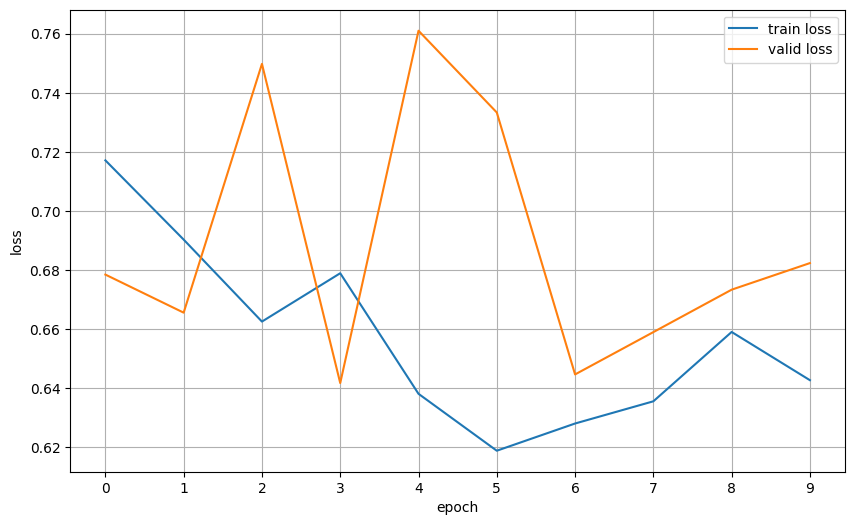

In [28]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

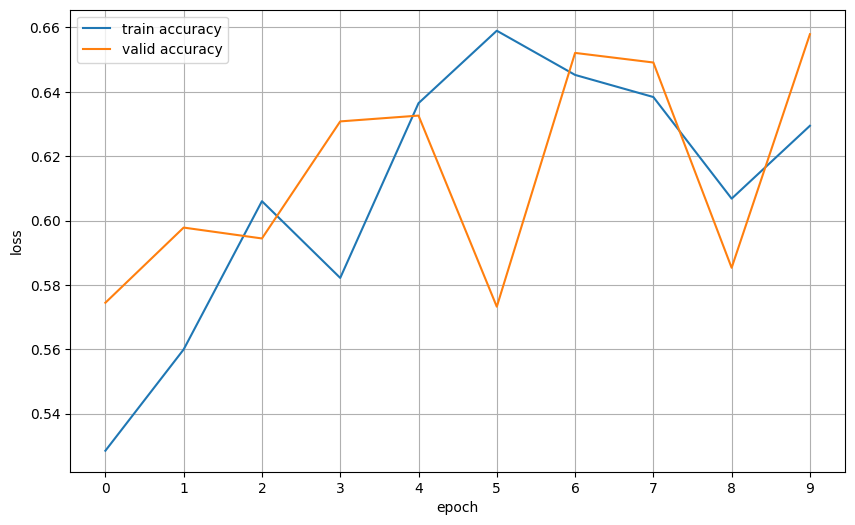

In [29]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [30]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [31]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [32]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.6580556631088257)

In [33]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.9172079563140869)

In [34]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.5298693180084229)

In [35]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.7524096369743347)

## Exercise 1: LSTM

The model should not be bad yet (specially if pretrained embeddings are used). Can you replace the RNN with a LSTM and check the results.

## Exercise 2: Attention and Transformer (hard)

Even as this is not a seq2seq tasks, it would be possible to use attention and transformer ideas here. For example the encoder part and then just use a more simple decoder. 